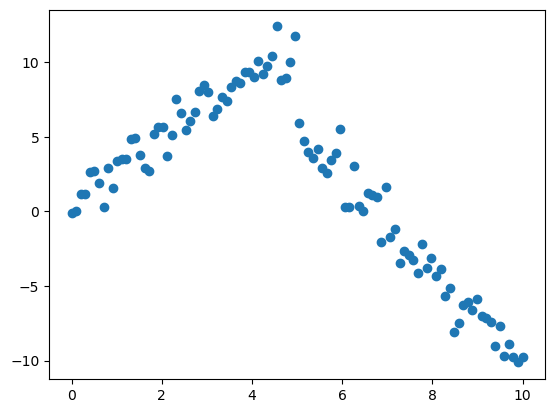

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Generate some synthetic data
torch.manual_seed(0)
N=500
x = torch.linspace(0, 10, N).unsqueeze(1)
y = torch.cat((x[:50] * 2 + 1, x[50:] * -3 + 20)) + torch.randn(100, 1)


# draw the data
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.show()


In [3]:
import pandas as pd
fn = '/gladstone/engelhardt/home/hvu/source/RNA_rates/splicingrates/simulations/tests/coverage_df.csv.gz'
df = pd.read_csv(fn, header = 0, index_col=None, sep = '\t')
print(df.head())
tdf = (df).copy()
tdf.reset_index(drop=True, inplace=True)
X = tdf.loc[:6480]['position'].values
Y = tdf.loc[:6480]['0'].values
X = X/1000
# turn X and Y into tensors
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

     0    1    2  position
0  335  148  141         0
1  335  148  140         1
2  335  148  140         2
3  335  148  140         3
4  335  148  139         4


In [4]:
print(X)
print(Y)

tensor([0.0000e+00, 1.0000e-03, 2.0000e-03,  ..., 6.4780e+00, 6.4790e+00,
        6.4800e+00])
tensor([335., 335., 335.,  ...,   1.,   1.,   1.])


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the piecewise linear model
class PiecewiseLinearModel(nn.Module):
    def __init__(self, px=None, gap=0.1, x_min=0, x_max=10):
        super(PiecewiseLinearModel, self).__init__()
        if px is None:
            px = torch.linspace(x_min, x_max, int((x_max - x_min) / gap) + 1)
        self.px = px
        self.xgap = px[1] - px[0]
        self.py = nn.Parameter(torch.zeros(len(px), dtype=torch.float32))

    def forward(self, x):
        # get the index of the models that x belongs to, should be integer
        idx = (x / self.xgap).long()  # this will round down
        slope = (self.py[idx + 1] - self.py[idx]) / self.xgap
        intercept = self.py[idx] - slope * self.px[idx]
        result = slope * x + intercept
        return result
    
    def fit(self, X, Y, criterion=nn.MSELoss(), optimizer=optim.Adam([py], lr=0.01), num_epochs=1000):
        for epoch in range(num_epochs):
            self.train()
            optimizer.zero_grad()
            outputs = self(X)  # given X, predict Y
            loss = criterion(outputs, Y)
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
                
    def print_model(self):
        print("Optimized py values:", self.py.data)
        print("Optimized px values:", self.px)
        return 


In [6]:
# px should be spanning X, from min to max
xgap=0.1
px = torch.linspace(X.min(), X.max(), int((X.max() - X.min()) / xgap) + 1)
model = PiecewiseLinearModel(px=px)
model.fit(X, Y)
model.print_model()

IndexError: index 65 is out of bounds for dimension 0 with size 65

In [1]:
import torch
import gpytorch
from matplotlib import pyplot as plt

# Generate some synthetic data
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * torch.pi)) + torch.randn(train_x.size()) * 0.2

# Define the GP Model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 50
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print(f'Iter {i+1}/{training_iterations} - Loss: {loss.item():.3f}')
    optimizer.step()

# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
test_x = torch.linspace(0, 1, 51)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Plot the results
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(10, 6))
    # Training data is red, predictions are blue
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.numpy(), 
                    observed_pred.mean.numpy() - 2*observed_pred.variance.numpy(), 
                    observed_pred.mean.numpy() + 2*observed_pred.variance.numpy(), 
                    alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.show()


ModuleNotFoundError: No module named 'gpytorch'